In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pe
import build_data
from build_data import ext_pyomo_vals
import model as m
import seaborn as sns
import pandas as pd
import os
import dotenv

In [2]:
# Set up variables
_import_factor = 400 # -> increase the maximum import capacity
_stor_factor = 600 # -> increase the storage capacity
_specific_date='2019-11-06' # -> Change date
_time_step = 60 # -> Change time step
_update_forecast = False # -> True to have forecast updat in the operation
_save_plots = True # -> True to save the plots

#Comentarios sobre performance de dias
#Dia 6 corre rapido
#ao fim do dia 13 as previsões sao maiores do q o consumo real
#dia 16/17 é um exemplo de uma pessima previsão

In [3]:
conf = dotenv.dotenv_values()
path_to_solver = conf["PATH_TO_SOLVER"]

In [4]:
project_colors = {"green": "#58c1ae", "blue": "#0e73b9", "lightgreen": "#cdd451",
                  "babyblue": "#5ebcea", "orange": "#e58033", "yellow": "#eacf5e",
                  "raw": "#ece9d6"}
project_colors_list = ["#58c1ae", "#0e73b9", "#cdd451", "#5ebcea", "#e58033","#eacf5e","#ece9d6"] 

In [5]:
#Build forecat data
Data_forecast = build_data.Data()  # Create data object -> This object will store all the data from the excel
Data_forecast.change_time_step(_time_step) 
#Data_forecast.increase_import_limit(factor=_import_factor)

#@TODO São essas duas: get_gen_forecast_data_from_db e get_loads_forecast_data_from_db que estão a dar problema
Data_forecast.get_gen_forecast_data_from_db(specific_date=_specific_date, end = 24*60//_time_step, experiment_id = 17, time_step=_time_step)
Data_forecast.get_loads_forecast_data_from_db(specific_date=_specific_date, end = 24*60//_time_step, experiment_id = 23, time_step=_time_step)

#Data_forecast.increase_storage_capacity(factor=_stor_factor)

#Increase number of charging stations and vehicles -> Can only increase by a factor
#Number of VE is multiple of 5 and number of CS is multiple of 3
#Data_forecast.increase_number_of_charging_station(factor=3)
#Data_forecast.increase_number_of_vehicle(factor=2)
#Data_forecast.creat_new_cs_schedual()
print("(#CS, #VE, #Time-Steps) -> ", Data_forecast.get_data().vehicle['schedule_cs_usage'].shape)


(#CS, #VE, #Time-Steps) ->  (4, 7, 24)


In [6]:
#print(Data_forecast.get_data().charging_station["p_charge_limit"])
#print(Data_forecast.get_data().charging_station.keys())

In [7]:
# Create the model for the forecast
model_forecast = m.creat_model(Data_forecast.get_data(), end = 24*60//_time_step+1)
# Define the model objects which object has parameters, variables and constraints
model_forecast = m.def_import_export( Data_forecast.get_data(), model_forecast)
model_forecast = m.def_gen(Data_forecast.get_data(), model_forecast)
model_forecast = m.def_loads(Data_forecast.get_data(), model_forecast)
model_forecast = m.def_storage(Data_forecast.get_data(), model_forecast)
model_forecast = m.def_v2g(Data_forecast.get_data(), model_forecast)
model_forecast = m.def_charging_stations(Data_forecast.get_data(), model_forecast)
#Define the balance and objective function
model_forecast.balanceEq = pe.Constraint(model_forecast.t, rule=m._balanceEq,
                                doc='Balance equation')

model_forecast.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                           doc='Objective function')

model_forecast.write('res_community.lp', io_options={'symbolic_solver_labels': True})

# Solve the model
solver_forecast = pe.SolverFactory('cplex', executable=path_to_solver)
solver_forecast.options['LogFile'] = 'res_community.log'

results_forecast = solver_forecast.solve(model_forecast)
# results_forecast.write()
objective_value = pe.value(model_forecast.objFn)
print(f"The value of the objective function is: {objective_value}")

#  Result extraction - Saving the results on CSVs:

folder = 'results_forecast'

if not os.path.exists(folder):
    os.makedirs(folder)

# Generation
if not os.path.exists(folder + '/generation/'):
    os.makedirs(folder + '/generation/')

result_genActPower = ext_pyomo_vals(model_forecast.genActPower)
result_genActPower.to_csv(folder + '/generation/result_genActPower.csv')

result_genExcActPower = ext_pyomo_vals(model_forecast.genExcPower)
result_genExcActPower.to_csv(folder + '/generation/result_genExcActPower.csv')

# Imports/Exports
if not os.path.exists(folder + '/power/'):
    os.makedirs(folder + '/power/')

result_pimp= ext_pyomo_vals(model_forecast.imports)
result_pimp.to_csv(folder + '/power/result_pimp.csv')

result_pexp = ext_pyomo_vals(model_forecast.exports)
result_pexp.to_csv(folder + '/power/result_pexp.csv')

# Loads
if not os.path.exists(folder + '/loads/'):
    os.makedirs(folder + '/loads/')

result_loadRedActPower = ext_pyomo_vals(model_forecast.loadRedActPower)
result_loadRedActPower.to_csv(folder + '/loads/result_loadRedActPower.csv')

result_loadCutActPower = ext_pyomo_vals(model_forecast.loadCutActPower)
result_loadCutActPower.to_csv(folder + '/loads/result_loadCutActPower.csv')

result_loadENS = ext_pyomo_vals(model_forecast.loadENS)
result_loadENS.to_csv(folder + '/loads/result_loadENS.csv')

# Storage
if not os.path.exists(folder + '/storage/'):
    os.makedirs(folder + '/storage/')
    
result_storDchActPower = ext_pyomo_vals(model_forecast.storDischarge)
result_storDchActPower.to_csv(folder + '/storage/result_storDchActPower.csv')

result_storChActPower = ext_pyomo_vals(model_forecast.storCharge)
result_storChActPower.to_csv(folder + '/storage/result_storChActPower.csv')

result_storEnerState = ext_pyomo_vals(model_forecast.storState)
result_storEnerState.to_csv(folder + '/storage/result_storEnerState.csv')

result_storRelax = ext_pyomo_vals(model_forecast.storRelax)
result_storRelax.to_csv(folder + '/storage/result_storRelax.csv')

result_storScheduleChRelax = ext_pyomo_vals(model_forecast.storScheduleChRelax)
result_storScheduleChRelax.to_csv(folder + '/storage/result_storScheduleChRelax.csv')

result_storScheduleDchRelax = ext_pyomo_vals(model_forecast.storScheduleDchRelax)
result_storScheduleDchRelax.to_csv(folder + '/storage/result_storScheduleDchRelax.csv')

# V2G
if not os.path.exists(folder + '/v2g/'):
    os.makedirs(folder + '/v2g/')
    
result_v2gDchActPower = ext_pyomo_vals(model_forecast.v2gDischarge)
result_v2gDchActPower.to_csv(folder + '/v2g/result_v2gDchActPower.csv')

result_v2gChActPower = ext_pyomo_vals(model_forecast.v2gCharge)
result_v2gChActPower.to_csv(folder + '/v2g/result_v2gChActPower.csv')

result_v2gEnerState = ext_pyomo_vals(model_forecast.v2gState)
result_v2gEnerState.to_csv(folder + '/v2g/result_v2gEnerState.csv')

result_v2gRelax = ext_pyomo_vals(model_forecast.v2gRelax)
result_v2gRelax.to_csv(folder + '/v2g/result_v2gRelax.csv')

result_v2gScheduleChRelax = ext_pyomo_vals(model_forecast.v2gScheduleChRelax)
result_v2gScheduleChRelax.to_csv(folder + '/v2g/result_v2gScheduleChRelax.csv')

result_v2gScheduleDchRelax = ext_pyomo_vals(model_forecast.v2gScheduleDchRelax)
result_v2gScheduleDchRelax.to_csv(folder + '/v2g/result_v2gScheduleDchRelax.csv')


# Charging Stations
if not os.path.exists(folder + '/cs/'):
    os.makedirs(folder + '/cs/')
   
result_csActPower = ext_pyomo_vals(model_forecast.csCharge)
result_csActPower.to_csv(folder + '/cs/result_csActPower.csv')

result_csActPowerNet = ext_pyomo_vals(model_forecast.csNetCharge)
result_csActPowerNet.to_csv(folder + '/cs/result_csActPowerNet.csv')


# Booleans
if not os.path.exists(folder + '/bool/'):
    os.makedirs(folder + '/bool/')
 
result_genXo = ext_pyomo_vals(model_forecast.genXo)
result_genXo.to_csv(folder + '/bool/result_genXo.csv')

result_loadXo = ext_pyomo_vals(model_forecast.loadXo)
result_loadXo.to_csv(folder + '/bool/result_loadXo.csv')

result_storDchXo = ext_pyomo_vals(model_forecast.storDchXo)
result_storDchXo.to_csv(folder + '/bool/result_storDchXo.csv')

result_storChXo = ext_pyomo_vals(model_forecast.storChXo)
result_storChXo.to_csv(folder + '/bool/result_storChXo.csv')

result_v2gDchXo= ext_pyomo_vals(model_forecast.v2gDchXo)
result_v2gDchXo.to_csv(folder + '/bool/result_v2gDchXo.csv')

result_v2gChXo = ext_pyomo_vals(model_forecast.v2gChXo)
result_v2gChXo.to_csv(folder + '/bool/result_v2gChXo.csv')


The value of the objective function is: 2516866.885969108


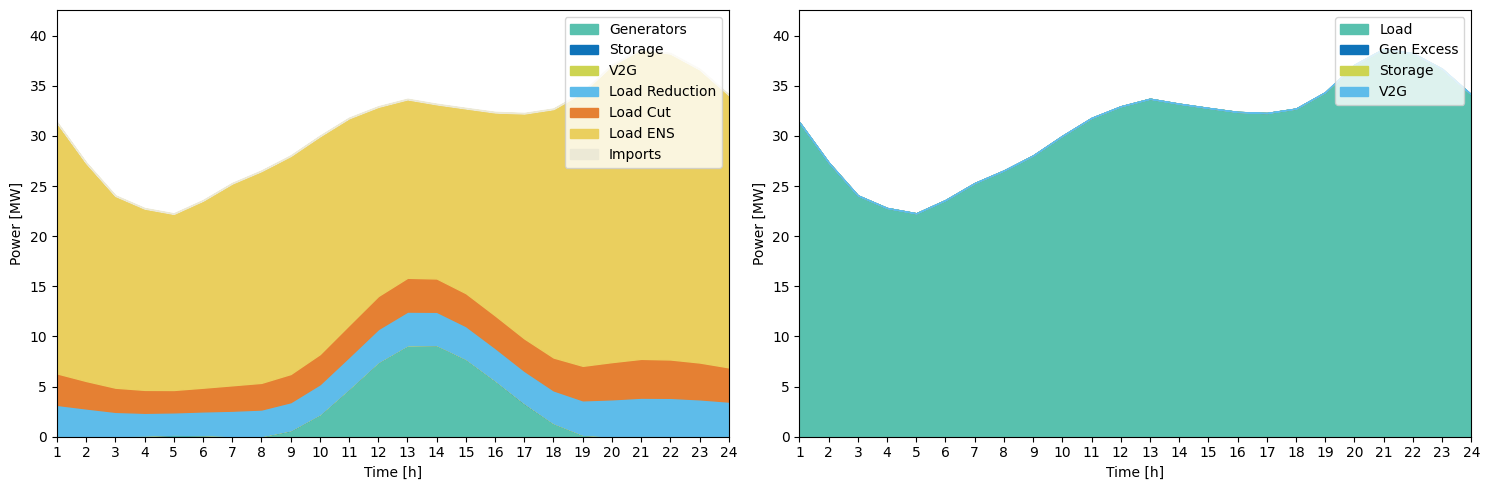

In [8]:
m.plot_profile(result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    model_forecast,
    Data_forecast,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    save = _save_plots, path=f'plots/{_specific_date}', name = f'forecast-{_specific_date}-step-{_time_step}')

In [9]:
# This function put on a excel all the data that was ploted on the previous part (plot_profile function)
m.export_profile_to_excel(
    result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    model_forecast,
    Data_forecast,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    path='./results_forecast',  
    name='profile_data.xlsx'   
)

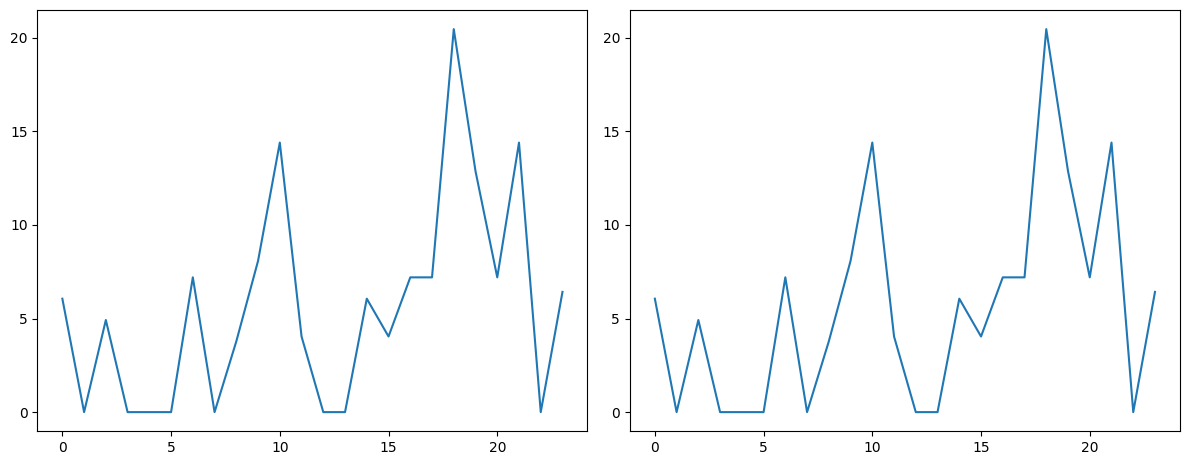

In [10]:
# PLot the results of the eletric vehicles and charging stations
if result_v2gEnerState.values.shape[0] == 5:
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 10))

    for i in range(result_csActPower.values.shape[0]):
        axs[i, 0].plot(result_csActPower.values[i])
        axs[i, 0].set_title(f'Charging Station {i+1}')
        axs[i, 0].set_ylabel('Power [kW]')
        axs[i, 0].set_xlabel('Time Step')
    for i in range(result_v2gEnerState.values.shape[0]):
        axs[i, 1].plot(result_v2gEnerState.values[i])
        axs[i, 1].set_title(f'EV {i+1}')
        axs[i, 1].set_ylabel('Energy [kWh]')
        axs[i, 1].set_xlabel('Time Step')
else:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  
    axs[0].plot(np.sum(result_csActPower.values, axis=0))
    axs[1].plot(np.sum(result_v2gChActPower.values, axis=0))  
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust the top to fit the suptitle
plt.savefig("./plots/cs_ev.png", dpi=300, bbox_inches='tight')

plt.show()

In [11]:
# Store the storage and v2g planing made by the model
schedule_storageCh =  np.array(result_storChActPower)
schedule_storageDch =  np.array(result_storDchActPower)
schedule_v2gCh =  np.array(result_v2gChActPower)
schedule_v2gDch =  np.array(result_v2gDchActPower)

The value of the objective function is: 2405086.712041631


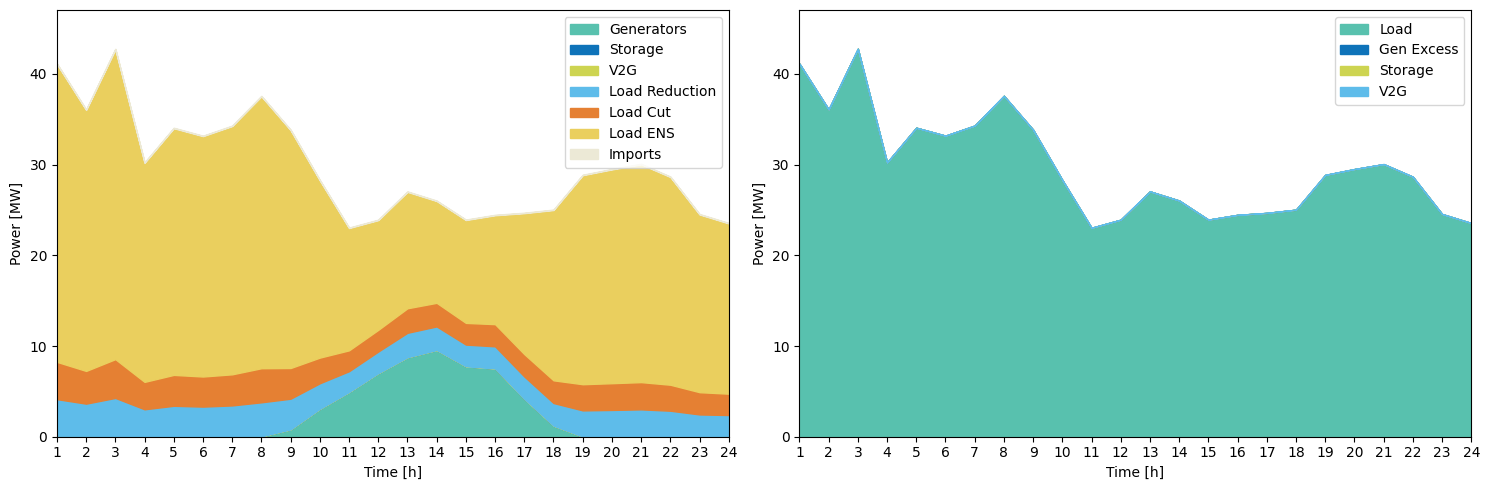

In [12]:
# Build the true data
True_Data = build_data.Data()

True_Data.change_time_step(_time_step)
#True_Data.increase_import_limit(factor=_import_factor)
True_Data.get_gen_data_from_db(specific_date=_specific_date, end = 24*60//_time_step, time_step=_time_step)
True_Data.get_loads_data_from_db(specific_date=_specific_date, end = 24*60//_time_step, time_step=_time_step)
#True_Data.increase_storage_capacity(factor=_stor_factor)
#True_Data.increase_number_of_charging_station(factor=3)
#True_Data.increase_number_of_vehicle(factor=2)
#True_Data.creat_new_cs_schedual()

# Create the model for the true data
model_true_true = m.creat_model(True_Data.get_data(), end = 24*60//_time_step+1)

model_true_true = m.def_import_export( True_Data.get_data(), model_true_true)
model_true_true = m.def_gen(True_Data.get_data(), model_true_true)
model_true_true = m.def_loads(True_Data.get_data(), model_true_true)
model_true_true = m.def_storage(True_Data.get_data(), model_true_true, forecast=True)
model_true_true = m.def_v2g(True_Data.get_data(), model_true_true, forecast=True)
model_true_true = m.def_charging_stations(True_Data.get_data(), model_true_true)

model_true_true.balanceEq = pe.Constraint(model_true_true.t, rule=m._balanceEq,
                                doc='Balance equation')
model_true_true.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                           doc='Objective function')

model_true_true.write('res_community.lp', io_options={'symbolic_solver_labels': True})

# Solve the model
solver_true_true = pe.SolverFactory('cplex', executable=path_to_solver)
solver_true_true.options['LogFile'] = 'res_community.log'

results_true_true = solver_true_true.solve(model_true_true)
# results_true.write()
objective_value = pe.value(model_true_true.objFn)
print(f"The value of the objective function is: {objective_value}")

#  Result extraction - Saving the results on CSVs:

folder = 'results_real'

if not os.path.exists(folder):
    os.makedirs(folder)

# Generation

if not os.path.exists(folder + '/generation/'):
    os.makedirs(folder + '/generation/')

result_genActPower_true_true = ext_pyomo_vals(model_true_true.genActPower)
result_genActPower_true_true.to_csv(folder + '/generation/result_genActPower.csv')

result_genExcActPower_true_true = ext_pyomo_vals(model_true_true.genExcPower)
result_genExcActPower_true_true.to_csv(folder + '/generation/result_genExcActPower.csv')


# Imports/Exports
if not os.path.exists(folder + '/power/'):
    os.makedirs(folder + '/power/')
    
result_pimp_true_true = ext_pyomo_vals(model_true_true.imports)
result_pimp_true_true.to_csv(folder + '/power/result_pimp.csv')

result_pexp_true_true = ext_pyomo_vals(model_true_true.exports)
result_pexp_true_true.to_csv(folder + '/power/result_pexp.csv')

# Loads
if not os.path.exists(folder + '/loads/'):
    os.makedirs(folder + '/loads/')

result_loadRedActPower_true_true = ext_pyomo_vals(model_true_true.loadRedActPower)
result_loadRedActPower_true_true.to_csv(folder + '/loads/result_loadRedActPower.csv')

result_loadCutActPower_true_true = ext_pyomo_vals(model_true_true.loadCutActPower)
result_loadCutActPower_true_true.to_csv(folder + '/loads/result_loadCutActPower.csv')

result_loadENS_true_true = ext_pyomo_vals(model_true_true.loadENS)
result_loadENS_true_true.to_csv(folder + '/loads/result_loadENS.csv')


# Storage
if not os.path.exists(folder + '/storage/'):
    os.makedirs(folder + '/storage/')

result_storDchActPower_true_true = ext_pyomo_vals(model_true_true.storDischarge)
result_storDchActPower_true_true.to_csv(folder + '/storage/result_storDchActPower.csv')

result_storChActPower_true_true = ext_pyomo_vals(model_true_true.storCharge)
result_storChActPower_true_true.to_csv(folder + '/storage/result_storChActPower.csv')

result_storEnerState_true_true = ext_pyomo_vals(model_true_true.storState)
result_storEnerState_true_true.to_csv(folder + '/storage/result_storEnerState.csv')

# V2G
if not os.path.exists(folder + '/v2g/'):
    os.makedirs(folder + '/v2g/')

result_v2gDchActPower_true_true = ext_pyomo_vals(model_true_true.v2gDischarge)
result_v2gDchActPower_true_true.to_csv(folder + '/v2g/result_v2gDchActPower.csv')

result_v2gChActPower_true_true = ext_pyomo_vals(model_true_true.v2gCharge)
result_v2gChActPower_true_true.to_csv(folder + '/v2g/result_v2gChActPower.csv')

result_v2gEnerState_true_true = ext_pyomo_vals(model_true_true.v2gState)
result_v2gEnerState_true_true.to_csv(folder + '/v2g/result_v2gEnerState.csv')

# Charging Stations
if not os.path.exists(folder + '/cs/'):
    os.makedirs(folder + '/cs/')

result_csActPower_true_true = ext_pyomo_vals(model_true_true.csCharge)
result_csActPower_true_true.to_csv(folder + '/cs/result_csActPower.csv')

result_csActPowerNet_true_true = ext_pyomo_vals(model_true_true.csNetCharge)
result_csActPowerNet_true_true.to_csv(folder + '/cs/result_csActPowerNet.csv')


# Booleans
if not os.path.exists(folder + '/bool/'):
    os.makedirs(folder + '/bool/')
result_genXo_true_true = ext_pyomo_vals(model_true_true.genXo)
result_genXo_true_true.to_csv(folder + '/bool/result_genXo.csv')

result_loadXo_true_true = ext_pyomo_vals(model_true_true.loadXo)
result_loadXo_true_true.to_csv(folder + '/bool/result_loadXo.csv')

result_storDchXo_true_true = ext_pyomo_vals(model_true_true.storDchXo)
result_storDchXo_true_true.to_csv(folder + '/bool/result_storDchXo.csv')

result_storChXo_true_true = ext_pyomo_vals(model_true_true.storChXo)
result_storChXo_true_true.to_csv(folder + '/bool/result_storChXo.csv')

result_v2gDchXo_true_true = ext_pyomo_vals(model_true_true.v2gDchXo)
result_v2gDchXo_true_true.to_csv(folder + '/bool/result_v2gDchXo.csv')

result_v2gChXo_true_true = ext_pyomo_vals(model_true_true.v2gChXo)
result_v2gChXo_true_true.to_csv(folder + '/bool/result_v2gChXo.csv')


m.plot_profile(result_genActPower=result_genActPower_true_true, result_storDchActPower = result_storDchActPower_true_true,
               result_v2gDchActPower=result_v2gDchActPower_true_true, result_loadRedActPower=result_loadRedActPower_true_true,
               result_loadCutActPower=result_loadCutActPower_true_true, result_loadENS=result_loadENS_true_true,
               result_pimp=result_pimp_true_true, model = model_true_true, Data = True_Data, result_genExcActPower=result_genExcActPower_true_true,
               result_storChActPower=result_storChActPower_true_true, result_v2gChActPower=result_v2gChActPower_true_true,
               save = _save_plots, path=f'plots/{_specific_date}', name = f'measured-{_specific_date}-step-{_time_step}')

In [13]:
#Operation/Control @TODO Célula que está a dar problema dependendo dos inputs

'''Eu acho que entendi o problema. Linha 410 do model.py diz if not forecast:
model.v2gScheduleCh = pe.Param(...). O caso 3 tem forecast, então ele não entra nesse if e não 
inicializa esse parametro. Como o parametro é None, ele não consegue fazer a restrição, 
v2gFollowScheduleChEq.'''

all_data = []
all_models = []
results_dict = {}
# results_dict = m.store_results(1, results_dict, result_pimp, result_pexp, result_genActPower, result_genExcActPower, result_genXo, result_loadRedActPower, result_loadCutActPower, result_loadENS, result_loadXo, result_storEnerState, result_storDchActPower, result_storChActPower, result_storDchXo, result_storChXo, result_storScheduleChRelax, result_storScheduleDchRelax, result_v2gChActPower, result_v2gDchActPower, result_v2gEnerState, result_v2gRelax, result_v2gDchXo, result_v2gChXo, result_v2gScheduleChRelax, result_v2gScheduleDchRelax, result_csActPower, result_csActPowerNet)

integral_of_error_gen = np.zeros((5, 1))
integral_of_error_load = np.zeros((5, 1))
forecast_error_load_at_time = True_Data.get_data().load['p_forecast'][:, :] - Data_forecast.get_data().load['p_forecast'][:, :] 
forecast_error_gen_at_time = True_Data.get_data().generator['p_forecast'][:, :] - Data_forecast.get_data().generator['p_forecast'][:, :]

for i in range(1, 24*60//_time_step+1):

    print(i)
    integral_of_error_gen = integral_of_error_gen + forecast_error_gen_at_time[:, i-1].reshape(5, 1)
    integral_of_error_load = integral_of_error_load + forecast_error_load_at_time[:, i-1].reshape(5, 1)
    
    #Build the data for each time step with the forecast data and the true data
    Data_at_time = build_data.Data()
    Data_at_time.change_time_step(_time_step)
    #Data_at_time.increase_import_limit(factor=_import_factor)
    #Data_at_time.increase_storage_capacity(factor=_stor_factor)
    #Data_at_time.increase_number_of_charging_station(factor=3)
    #Data_at_time.increase_number_of_vehicle(factor=2)
    #Data_at_time.creat_new_cs_schedual()
    
    Data_at_time.get_gen_forecast_data_from_db(specific_date=_specific_date, experiment_id = 17, start=i, end = 24*60//_time_step, time_step=_time_step)
    Data_at_time.get_gen_data_from_db(specific_date=_specific_date, start=0, end = i, time_step=_time_step)
    
    Data_at_time.get_loads_forecast_data_from_db(specific_date=_specific_date, experiment_id = 23, start=i, end = 24*60//_time_step, time_step=_time_step)
    Data_at_time.get_loads_data_from_db(specific_date=_specific_date, start=0, end = i, time_step=_time_step)

    if _update_forecast:
        Data_at_time.update_forecast_integral(integral_of_error_gen / i , integral_of_error_load / i , i)

    forecast_error_load_at_time = True_Data.get_data().load['p_forecast'][:, :] - Data_at_time.get_data().load['p_forecast'][:, :] 
    forecast_error_gen_at_time = True_Data.get_data().generator['p_forecast'][:, :] - Data_at_time.get_data().generator['p_forecast'][:, :]


    if i != 1:
        #Update the initial state of the storage with the final state of the storage of the previous time step
        Data_at_time.change_initial_state_storage(np.array(results_dict[i-1]['storStateInit'])/Data_at_time.get_data().storage['energy_capacity'])

    all_data.append(Data_at_time)

    # Create the model 
    model_at_time = pe.ConcreteModel()
    model_at_time.t = pe.Set(initialize=np.arange(i, 24*60//_time_step+1),
                 doc='Time periods') 

    model_at_time = m.def_import_export(Data_at_time.get_data(), model_at_time, i=i)
    model_at_time = m.def_gen(Data_at_time.get_data(), model_at_time, i=i)
    model_at_time = m.def_loads(Data_at_time.get_data(), model_at_time, i=i)
    model_at_time = m.def_storage(Data_at_time.get_data(), model_at_time, i=i)
    model_at_time = m.def_v2g(Data_at_time.get_data(), model_at_time, i=i,
                            forecast=False, schedule_v2gCh=schedule_v2gCh, schedule_v2gDch=schedule_v2gDch)
    model_at_time = m.def_charging_stations(Data_at_time.get_data(), model_at_time, i=i)
    model_at_time.balanceEq = pe.Constraint(model_at_time.t, rule=m._balanceEq, doc='Balance equation')

    model_at_time.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                            doc='Objective function')

    model_at_time.write('res_community.lp', io_options={'symbolic_solver_labels': True})

    # Solve the model
    solver_forecast = pe.SolverFactory('cplex', executable=path_to_solver)
    solver_forecast.options['LogFile'] = 'res_community.log'

    results_at_time = solver_forecast.solve(model_at_time)
    # results_at_time.write()
    objective_value = pe.value(model_at_time.objFn)
    # print(f"The value of the objective function is: {objective_value}")
    all_models.append(model_at_time)
    
    
    #  Result extraction - Saving the results on CSVs:
    folder = 'results_forecast&real'

    if not os.path.exists(folder):
        os.makedirs(folder)

    if True:
        # Generation
        if not os.path.exists(folder + '/generation/'):
            os.makedirs(folder + '/generation/')

        result_genActPower = ext_pyomo_vals(model_at_time.genActPower)
        result_genActPower.to_csv(folder + '/generation/result_genActPower.csv')

        result_genExcActPower = ext_pyomo_vals(model_at_time.genExcPower)
        result_genExcActPower.to_csv(folder + '/generation/result_genExcActPower.csv')

        # Imports/Exports
        if not os.path.exists(folder + '/power/'):
            os.makedirs(folder + '/power/')

        result_pimp= ext_pyomo_vals(model_at_time.imports)
        result_pimp.to_csv(folder + '/power/result_pimp.csv')

        result_pexp = ext_pyomo_vals(model_at_time.exports)
        result_pexp.to_csv(folder + '/power/result_pexp.csv')

        # Loads
        if not os.path.exists(folder + '/loads/'):
            os.makedirs(folder + '/loads/')

        result_loadRedActPower = ext_pyomo_vals(model_at_time.loadRedActPower)
        result_loadRedActPower.to_csv(folder + '/loads/result_loadRedActPower.csv')

        result_loadCutActPower = ext_pyomo_vals(model_at_time.loadCutActPower)
        result_loadCutActPower.to_csv(folder + '/loads/result_loadCutActPower.csv')

        result_loadENS = ext_pyomo_vals(model_at_time.loadENS)
        result_loadENS.to_csv(folder + '/loads/result_loadENS.csv')

        # Storage
        if not os.path.exists(folder + '/storage/'):
            os.makedirs(folder + '/storage/')
    
        result_storDchActPower = ext_pyomo_vals(model_at_time.storDischarge)
        result_storDchActPower.to_csv(folder + '/storage/result_storDchActPower.csv')

        result_storChActPower = ext_pyomo_vals(model_at_time.storCharge)
        result_storChActPower.to_csv(folder + '/storage/result_storChActPower.csv')

        result_storEnerState = ext_pyomo_vals(model_at_time.storState)
        result_storEnerState.to_csv(folder + '/storage/result_storEnerState.csv')

        result_storRelax = ext_pyomo_vals(model_at_time.storRelax)
        result_storRelax.to_csv(folder + '/storage/result_storRelax.csv')

        result_storScheduleChRelax = ext_pyomo_vals(model_at_time.storScheduleChRelax)
        result_storScheduleChRelax.to_csv(folder + '/storage/result_storScheduleChRelax.csv')

        result_storScheduleDchRelax = ext_pyomo_vals(model_at_time.storScheduleDchRelax)
        result_storScheduleDchRelax.to_csv(folder + '/storage/result_storScheduleDchRelax.csv')

        # V2G
        if not os.path.exists(folder + '/v2g/'):
            os.makedirs(folder + '/v2g/')
        
        result_v2gDchActPower = ext_pyomo_vals(model_at_time.v2gDischarge)
        result_v2gDchActPower.to_csv(folder + '/v2g/result_v2gDchActPower.csv')

        result_v2gChActPower = ext_pyomo_vals(model_at_time.v2gCharge)
        result_v2gChActPower.to_csv(folder + '/v2g/result_v2gChActPower.csv')

        result_v2gEnerState = ext_pyomo_vals(model_at_time.v2gState)
        result_v2gEnerState.to_csv(folder + '/v2g/result_v2gEnerState.csv')

        result_v2gRelax = ext_pyomo_vals(model_at_time.v2gRelax)
        result_v2gRelax.to_csv(folder + '/v2g/result_v2gRelax.csv')

        result_v2gScheduleChRelax = ext_pyomo_vals(model_at_time.v2gScheduleChRelax)
        result_v2gScheduleChRelax.to_csv(folder + '/v2g/result_v2gScheduleChRelax.csv')

        result_v2gScheduleDchRelax = ext_pyomo_vals(model_at_time.v2gScheduleDchRelax)
        result_v2gScheduleDchRelax.to_csv(folder + '/v2g/result_v2gScheduleDchRelax.csv')

        # Charging Stations
        if not os.path.exists(folder + '/cs/'):
            os.makedirs(folder + '/cs/')
        
        result_csActPower = ext_pyomo_vals(model_at_time.csCharge)
        result_csActPower.to_csv(folder + '/cs/result_csActPower.csv')

        result_csActPowerNet = ext_pyomo_vals(model_at_time.csNetCharge)
        result_csActPowerNet.to_csv(folder + '/cs/result_csActPowerNet.csv')

        # Booleans
        if not os.path.exists(folder + '/bool/'):
            os.makedirs(folder + '/bool/')
        result_genXo = ext_pyomo_vals(model_at_time.genXo)
        result_genXo.to_csv(folder + '/bool/result_genXo.csv')

        result_loadXo = ext_pyomo_vals(model_at_time.loadXo)
        result_loadXo.to_csv(folder + '/bool/result_loadXo.csv')

        result_storDchXo = ext_pyomo_vals(model_at_time.storDchXo)
        result_storDchXo.to_csv(folder + '/bool/result_storDchXo.csv')

        result_storChXo = ext_pyomo_vals(model_at_time.storChXo)
        result_storChXo.to_csv(folder + '/bool/result_storChXo.csv')

        result_v2gDchXo= ext_pyomo_vals(model_at_time.v2gDchXo)
        result_v2gDchXo.to_csv(folder + '/bool/result_v2gDchXo.csv')

        result_v2gChXo = ext_pyomo_vals(model_at_time.v2gChXo)
        result_v2gChXo.to_csv(folder + '/bool/result_v2gChXo.csv')

    
    # Store results in a dictionary
    results_dict = m.store_results(i, results_dict, result_pimp, result_pexp, result_genActPower, result_genExcActPower,
                                   result_genXo, result_loadRedActPower, result_loadCutActPower, result_loadENS,
                                   result_loadXo, result_storEnerState, result_storDchActPower,
                                   result_storChActPower, result_storDchXo, result_storChXo,
                                   result_storScheduleChRelax, result_storScheduleDchRelax,
                                   result_v2gChActPower, result_v2gDchActPower, result_v2gEnerState,
                                   result_v2gRelax, result_v2gDchXo, result_v2gChXo, result_v2gScheduleChRelax,
                                   result_v2gScheduleDchRelax, result_csActPower, result_csActPowerNet)

    # m.plot_profile(result_genActPower,result_storDchActPower, result_v2gDchActPower,result_loadRedActPower,result_loadCutActPower,
    # result_loadENS,result_pimp, model_at_time,Data_at_time, result_genExcActPower, result_storChActPower, result_v2gChActPower, i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


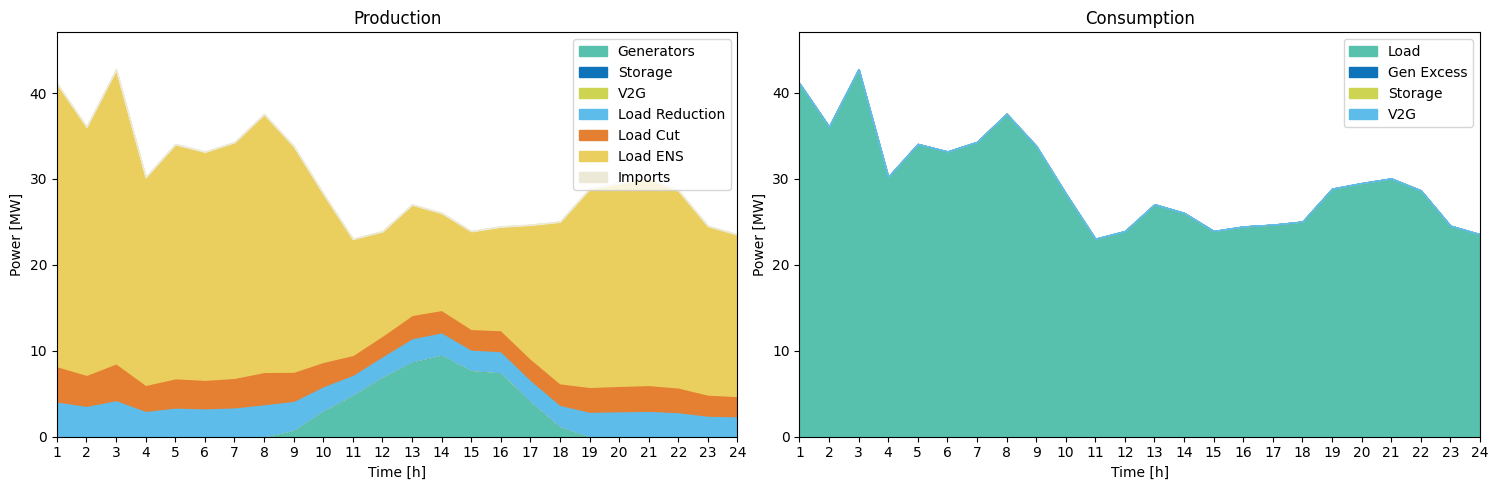

In [14]:
#Plot the operation of the community results

result_genActPower = np.array([results_dict[hour]['genActPowerInit'] for hour in sorted(results_dict.keys())])
result_storDchActPower = np.array([results_dict[hour]['storDischargeInit'] for hour in sorted(results_dict.keys())])
result_v2gDchActPower = np.array([results_dict[hour]['v2gDischargeInit'] for hour in sorted(results_dict.keys())])
result_loadRedActPower = np.array([results_dict[hour]['loadRedActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadCutActPower = np.array([results_dict[hour]['loadCutActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadENS = np.array([results_dict[hour]['loadENSInit'] for hour in sorted(results_dict.keys())])
result_pimp = np.array([results_dict[hour]['importsInit'] for hour in sorted(results_dict.keys())])
result_genExcActPower = np.array([results_dict[hour]['genExcPowerInit'] for hour in sorted(results_dict.keys())])
result_storChActPower = np.array([results_dict[hour]['storChargeInit'] for hour in sorted(results_dict.keys())])
result_v2gChActPower = np.array([results_dict[hour]['v2gChargeInit'] for hour in sorted(results_dict.keys())])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# True Production
y1 = sum([result_genActPower[:, i].astype(float) for i in range(result_genActPower.shape[1])]) / 1000
y2 = sum([result_storDchActPower[:,i] for i in range(result_storDchActPower.shape[1])]) / 1000
y3 = sum([result_v2gDchActPower[:, i] for i in range(result_v2gDchActPower.shape[1])]) / 1000
y4 = sum([result_loadRedActPower[:, i] for i in range(result_loadRedActPower.shape[1])]) / 1000
y5 = sum([result_loadCutActPower[:, i] for i in range(result_loadCutActPower.shape[1])]) / 1000
y6 = sum([result_loadENS[:, i] for i in range(result_loadENS.shape[1])]) / 1000

y7 = result_pimp.squeeze() / 1000

axs[0].fill_between(list(range(1, len(y1)+1)), np.zeros(len(y1)), y1, color=project_colors_list[0], label="Generators")
axs[0].fill_between(list(range(1, len(y2)+1)), y1, y1 + y2, color=project_colors_list[1], label="Storage")
axs[0].fill_between(list(range(1, len(y3)+1)), y1 + y2, y1 + y2 + y3, color=project_colors_list[2], label="V2G")
axs[0].fill_between(list(range(1, len(y4)+1)), y1 + y2 + y3, y1 + y2 + y3 + y4, color=project_colors_list[3], label="Load Reduction")
axs[0].fill_between(list(range(1, len(y5)+1)), y1 + y2 + y3 + y4, y1 + y2 + y3 + y4 + y5, color=project_colors_list[4], label="Load Cut")
axs[0].fill_between(list(range(1, len(y6)+1)), y1 + y2 + y3 + y4 + y5, y1 + y2 + y3 + y4 + y5 + y6, color=project_colors_list[5], label="Load ENS")
axs[0].fill_between(list(range(1, len(y7)+1)), y1 + y2 + y3 + y4 + y5 + y6, y1 + y2 + y3 + y4 + y5 + y6 + y7, color=project_colors_list[6], label="Imports")
axs[0].set_ylim(0, 1.1*np.max(y1 + y2 + y3 + y4 + y5 + y6 + y7))
axs[0].set_xlabel('Time [h]')
axs[0].set_ylabel('Power [MW]')
axs[0].set_title('Production')
axs[0].legend()

    # True Consumption
y1 = np.sum(True_Data.get_data().load['p_forecast'][:, 0:24*60//_time_step]*5, axis=0, dtype=np.float64) / 1000
y2 = sum([result_genExcActPower[:, i] for i in range(result_genExcActPower.shape[1])]) / 1000
y3 = sum([result_storChActPower[:, i] for i in range(result_storChActPower.shape[1])]) / 1000
y4 = sum([result_v2gChActPower[:, i] for i in range(result_v2gChActPower.shape[1])]) / 1000

axs[1].fill_between(list(range(1, len(y1)+1)), np.zeros(len(y1)), y1, color=project_colors_list[0], label="Load")
axs[1].fill_between(list(range(1, len(y2)+1)), y1, y1 + y2, color=project_colors_list[1], label="Gen Excess")
axs[1].fill_between(list(range(1, len(y3)+1)), y1 + y2, y1 + y2 + y3, color=project_colors_list[2], label="Storage")
axs[1].fill_between(list(range(1, len(y4)+1)), y1 + y2 + y3, y1 + y2 + y3 + y4, color=project_colors_list[3], label="V2G")
axs[1].set_ylim(0, 1.1*np.max(y1 + y2 + y3 + y4))
axs[1].set_xlabel('Time [h]')
axs[1].set_ylabel('Power [MW]')
axs[1].set_title('Consumption')
axs[1].legend()

axs[0].set_xlim(1, 24*60//_time_step)
axs[1].set_xlim(1, 24*60//_time_step)
plt.tight_layout()
ticks = range(1, 24*60//_time_step + 1)
axs[0].set_xticks(ticks)
axs[1].set_xticks(ticks)
directory = f'plots/{_specific_date}'
filename = f'operation-{_specific_date}-{_update_forecast}-step-{_time_step}.png'
full_path = os.path.join(directory, filename)

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the plot to the specified path
plt.savefig(full_path, dpi=300, bbox_inches='tight')

plt.show()


In [15]:
#Metrics
metric02 = m.metric02(np.array(result_pimp_true_true), np.array(result_pimp), np.array(result_loadRedActPower_true_true), np.array(result_loadRedActPower).T,
           np.array(result_loadCutActPower_true_true), np.array(result_loadCutActPower).T, np.array(result_loadENS_true_true), np.array(result_loadENS).T,
           a = 0.1, b = 0.2, c = 0.5, d = 1)

In [16]:
# Save the metrics to a file
forecast_error_load = np.abs(Data_forecast.get_data().load['p_forecast'][:, :] - True_Data.get_data().load['p_forecast'][:, :])
forecast_error_gen = np.abs(Data_forecast.get_data().generator['p_forecast'][:, :] - True_Data.get_data().generator['p_forecast'][:, :])

dataaaaaa = np.vstack([_specific_date,
                       _update_forecast,
                       np.sum(forecast_error_load, dtype=np.float64).reshape(-1, 1),
                       np.sum(forecast_error_gen, dtype=np.float64).reshape(-1, 1),
                       metric02]).T

df = pd.DataFrame(dataaaaaa, columns=['Date', 'Error propagation', 'Load Error', 'Gen Error', 'Metric02'])

file_path = 'mega_metric.xlsx'

print(df)
if os.path.exists(file_path):
        existing_data = pd.read_excel(file_path)
        combined_data = pd.concat([existing_data, df]).drop_duplicates(subset=['Date', 'Error propagation'], keep='first')
else:
    combined_data = df
combined_data.to_excel(file_path, index=False)

         Date Error propagation          Load Error          Gen Error  \
0  2019-11-06             False  48239.957471847534  13856.32673228065   

                  Metric02  
0  -0.00030453178488075547  
